# Transfer Entropy

# Hemispheric 

<div style="font-size: 13px; font-family: 'Times New Roman', Times, serif; background-color: #181818; color: #D0D0D0; padding: 20px; border-radius: 8px; margin: 10px; display: flex; flex-wrap: nowrap; justify-content: space-between;">
    <!-- Column 1 -->
    <div style="flex: 1; margin-right: 10px;">
        <h2>Introduction</h2>
        <p>
            This script performs analysis on EEG data using the concept of Transfer Entropy (TE). Specifically, it investigates the directionality of information flow between different EEG channels based on their 2D embeddings.
        </p>
        <h2>Data Preparation</h2>
        <p>
            Initially, the code unzips a dataset of 2D embedded EEG data for multiple channels. The embedded data is then loaded into Python, trimmed to a desired length, and grouped by hemisphere (left and right).
        </p>
    </div>
    <!-- Column 2 -->
    <div style="flex: 1; margin-left: 10px;">
        <h2>Analysis</h2>
        <p>
            Transfer Entropy calculations are conducted to quantify the amount of information flowing from one EEG channel to another. This is done after binning the data and applying the PyInform library’s TE function.
        </p>
        <p>
            The TE formula is represented as:
            \[
            TE_{X \rightarrow Y} = \sum_{y_{t+1}, y_t, x_t} p(y_{t+1}, y_t, x_t) \log \frac{p(y_{t+1} | y_t, x_t)}{p(y_{t+1} | y_t)}
            \]
            Here \(X\) and \(Y\) are random variables, \(p(y_{t+1}, y_t, x_t)\) is the joint probability distribution function, and \(p(y_{t+1} | y_t, x_t)\) and \(p(y_{t+1} | y_t)\) are conditional probability distribution functions.
        </p>
        </p>
    </div>
</div>

In [17]:
import zipfile
import numpy as np
import os
import shutil
from pyinform import transfer_entropy

# Path to the zipped 2D embedded data
zip_file_path = '/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Phase Space/2dembedded_data.zip'
extraction_dir = '/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Phase Space/temp_extraction'

embedding_data_list_2D = []

# Extract zipped data to a temporary directory
with zipfile.ZipFile(zip_file_path, 'r') as zipf:
    zipf.extractall(extraction_dir)

eeg_channels = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
                'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6',
                'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']

for channel in eeg_channels:
    file_path = os.path.join(extraction_dir, f'2dembedded_{channel}_data.npy')
    embedding_data = np.load(file_path)
    embedding_data_list_2D.append(embedding_data)


# Set the desired length
desired_length = 4227688

# Trim each array in embedding_data_list_2D to desired_length
embedding_data_list_2D_trimmed = [data[:desired_length] for data in embedding_data_list_2D]

left_channels = ['Fp1', 'F7', 'F3', 'FC5', 'M1', 'T7', 'C3', 'CP5', 'P7', 'P3', 'O1']
right_channels = ['Fp2', 'F8', 'F4', 'FC6', 'M2', 'T8', 'C4', 'CP6', 'P8', 'P4', 'O2']
central_channels = ['Fpz', 'Fz', 'FC1', 'FC2', 'Cz', 'CP1', 'CP2', 'Pz', 'POz', 'Oz']

# Cleanup: Optionally remove the extraction directory after loading the data
# shutil.rmtree(extraction_dir) 

# Group channels by hemisphere
left_indices = [eeg_channels.index(ch) for ch in left_channels]
right_indices = [eeg_channels.index(ch) for ch in right_channels]

# Compute average embeddings for left and right channels
left_embedding_avg = np.mean(np.array([embedding_data_list_2D_trimmed[i] for i in left_indices]), axis=0)
right_embedding_avg = np.mean(np.array([embedding_data_list_2D_trimmed[i] for i in right_indices]), axis=0)

# Use one of the dimensions (e.g., x-coordinate) for Transfer Entropy calculation
left_data = left_embedding_avg[:, 0]
right_data = right_embedding_avg[:, 0]

def bin_data(data, num_bins):
    hist, bins = np.histogram(data, bins=num_bins)
    binned_data = np.digitize(data, bins[:-1]) - 1  # subtract 1 to start binning from 0
    return binned_data

left_data_binned = bin_data(left_data, 1000)
right_data_binned = bin_data(right_data, 1000)

# Compute Transfer Entropy
k, l = 1, 1
try:
    TE_left_to_right = transfer_entropy(left_data_binned, right_data_binned, k)
    TE_right_to_left = transfer_entropy(right_data_binned, left_data_binned, k)

    print(f"Transfer Entropy from Left to Right (2D embeddings): {TE_left_to_right}")
    print(f"Transfer Entropy from Right to Left (2D embeddings): {TE_right_to_left}")
except Exception as e:
    print(f"Error computing Transfer Entropy: {e}")

Transfer Entropy from Left to Right (2D embeddings): 0.5814364131726154
Transfer Entropy from Right to Left (2D embeddings): 0.5016624825390452


# Feature extraction

In [27]:
WINDOW_SIZE = 1000  # Size of each window
STEP_SIZE = 500     # Size of each step between windows

def compute_transfer_entropy_sequence(left_data, right_data, window_size=WINDOW_SIZE, step_size=STEP_SIZE):
    """
    Compute Transfer Entropy for sliding windows of the data.
    
    :param left_data: Left hemisphere data
    :param right_data: Right hemisphere data
    :param window_size: Size of each window
    :param step_size: Size of each step between windows
    :return: Sequence of Transfer Entropy values
    """
    te_sequence = []

    for start in range(0, len(left_data) - window_size + 1, step_size):
        window_left_data = left_data[start:start+window_size]
        window_right_data = right_data[start:start+window_size]

        window_left_binned = bin_data(window_left_data, 1000)
        window_right_binned = bin_data(window_right_data, 1000)

        te_left_to_right = transfer_entropy(window_left_binned, window_right_binned, 1)
        te_sequence.append(te_left_to_right)

    return np.array(te_sequence)

# Compute the TE sequence for the averaged hemispheres
te_sequence = compute_transfer_entropy_sequence(left_data_binned, right_data_binned)

# For CNNs, you may reshape this sequence to suit the model's input shape.
# Get the nearest square greater than or equal to len(te_sequence)
next_square = int(np.ceil(np.sqrt(len(te_sequence)))) ** 2

# Create a zero-filled square matrix of shape (sqrt(next_square), sqrt(next_square))
cnn_input = np.zeros((int(np.sqrt(next_square)), int(np.sqrt(next_square))))

# Fill in the matrix with the values from te_sequence
cnn_input.flat[:len(te_sequence)] = te_sequence

# For RNNs, you can directly use te_sequence as a feature.
rnn_input = te_sequence

print(f"Shape for CNN input: {cnn_input.shape}")
print(f"Shape for RNN input: {rnn_input.shape}")

Shape for CNN input: (92, 92)
Shape for RNN input: (8454,)


# Save features

In [29]:
import os
import numpy as np

# Define the directory where you want to save the results
output_dir = "/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Transfer Entropy"

# Ensure the directory exists, if not, create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the computed TE sequence
np.save(os.path.join(output_dir, 'transfer_entropy_hemispheric_avg.npy'), te_sequence)

# Save the CNN input
np.save(os.path.join(output_dir, 'cnn_transfer_entropy_hemispheric_avg_input.npy'), cnn_input)

# Save the RNN input (which is the same as the TE sequence in this case)
np.save(os.path.join(output_dir, 'rnn_transfer_entropy_hemispheric_avg_input.npy'), rnn_input)

print(f"Data saved in {output_dir}")

Data saved in /home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Transfer Entropy


# Hemispherical Pairs

In [24]:
def compute_transfer_entropy_for_hemispheres(data, left_channels, right_channels, window_size=1000, step_size=500):
    """
    Compute Transfer Entropy for pairs of channels between left and right hemispheres over sliding windows of the data.
    
    :param data: EEG data
    :param left_channels: List of channels from the left hemisphere
    :param right_channels: List of channels from the right hemisphere
    :param window_size: Size of each window
    :param step_size: Size of each step between windows
    :return: Matrix of Transfer Entropy values; each row is a time window and each column a channel pair
    """
    te_matrix = []

    for ch1 in left_channels:
        for ch2 in right_channels:
            te_values = []
            for start in range(0, len(data[0]) - window_size + 1, step_size):
                ch1_data = data[eeg_channels.index(ch1)][start:start+window_size]
                ch2_data = data[eeg_channels.index(ch2)][start:start+window_size]

                ch1_data_binned = bin_data(ch1_data[:, 0], 1000)
                ch2_data_binned = bin_data(ch2_data[:, 0], 1000)

                te_ch1_to_ch2 = transfer_entropy(ch1_data_binned, ch2_data_binned, 1)
                te_values.append(te_ch1_to_ch2)
            
            te_matrix.append(te_values)

    return np.array(te_matrix)

# Compute transfer entropy for each channel pair between left and right hemispheres
te_matrix = compute_transfer_entropy_for_hemispheres(embedding_data_list_2D_trimmed, left_channels, right_channels)

# This te_matrix is suitable for CNN as it's 2D. 
# For RNN, you can consider each row of the te_matrix as a sequence of TE values for a particular channel pairing over time.

KeyboardInterrupt: 

# Regional

In [3]:
import zipfile
import numpy as np
import os
import shutil
from pyinform import transfer_entropy

# Path to the zipped 2D embedded data
zip_file_path = '/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Phase Space/2dembedded_data.zip'
extraction_dir = '/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Phase Space/temp_extraction'

embedding_data_list_2D = []

# Extract zipped data to a temporary directory
with zipfile.ZipFile(zip_file_path, 'r') as zipf:
    zipf.extractall(extraction_dir)

eeg_channels = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
                'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6',
                'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']

for channel in eeg_channels:
    file_path = os.path.join(extraction_dir, f'2dembedded_{channel}_data.npy')
    embedding_data = np.load(file_path)
    embedding_data_list_2D.append(embedding_data)

desired_length = 4227688
embedding_data_list_2D_trimmed = [data[:desired_length] for data in embedding_data_list_2D]

# Brain regions
frontal_channels = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8']
temporal_channels = ['T7', 'T8']
parietal_channels = ['CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8']
occipital_channels = ['O1', 'Oz', 'O2']

frontal_indices = [eeg_channels.index(ch) for ch in frontal_channels]
temporal_indices = [eeg_channels.index(ch) for ch in temporal_channels]
parietal_indices = [eeg_channels.index(ch) for ch in parietal_channels]
occipital_indices = [eeg_channels.index(ch) for ch in occipital_channels]

# Getting average for each region
frontal_data_avg = np.mean([embedding_data_list_2D_trimmed[i] for i in frontal_indices], axis=0)
temporal_data_avg = np.mean([embedding_data_list_2D_trimmed[i] for i in temporal_indices], axis=0)
parietal_data_avg = np.mean([embedding_data_list_2D_trimmed[i] for i in parietal_indices], axis=0)
occipital_data_avg = np.mean([embedding_data_list_2D_trimmed[i] for i in occipital_indices], axis=0)

# Use one of the dimensions for Transfer Entropy calculation
frontal_data = frontal_data_avg[:, 0]
temporal_data = temporal_data_avg[:, 0]
parietal_data = parietal_data_avg[:, 0]
occipital_data = occipital_data_avg[:, 0]

def bin_data(data, num_bins):
    hist, bins = np.histogram(data, bins=num_bins)
    binned_data = np.digitize(data, bins[:-1]) - 1
    return binned_data

frontal_data_binned = bin_data(frontal_data, 1000)
temporal_data_binned = bin_data(temporal_data, 1000)
parietal_data_binned = bin_data(parietal_data, 1000)
occipital_data_binned = bin_data(occipital_data, 1000)

# Store the regional data in a dictionary for easier processing
region_data_binned = {
    "Frontal": frontal_data_binned,
    "Temporal": temporal_data_binned,
    "Parietal": parietal_data_binned,
    "Occipital": occipital_data_binned
}

k = 1


# Directory to save the transfer entropy results
results_dir = '/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Transfer Entropy'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)  # Create the directory if it doesn't exist

# Dictionary to store results
TE_results = {}

# Compute and print the transfer entropy from each region to every other region
for source_region, source_data in region_data_binned.items():
    for target_region, target_data in region_data_binned.items():
        if source_region != target_region:
            try:
                TE_value = transfer_entropy(source_data, target_data, k)
                key = f"{source_region}_to_{target_region}"
                TE_results[key] = TE_value
                print(f"Transfer Entropy from {source_region} to {target_region} (2D embeddings): {TE_value}")
            except Exception as e:
                print(f"Error computing Transfer Entropy from {source_region} to {target_region}: {e}")

# Save the computed Transfer Entropy results
results_file_path = os.path.join(results_dir, 'regional_transfer_entropy_results.npy')
np.save(results_file_path, TE_results)

print(f"Transfer entropy results saved to: {results_file_path}")

Transfer Entropy from Frontal to Temporal (2D embeddings): 0.25110661733698914
Transfer Entropy from Frontal to Parietal (2D embeddings): 0.5773050773854287
Transfer Entropy from Frontal to Occipital (2D embeddings): 0.6741032253719645
Transfer Entropy from Temporal to Frontal (2D embeddings): 0.33752969048400794
Transfer Entropy from Temporal to Parietal (2D embeddings): 0.4711875861147353
Transfer Entropy from Temporal to Occipital (2D embeddings): 0.6126095442734832
Transfer Entropy from Parietal to Frontal (2D embeddings): 0.38813154044068165
Transfer Entropy from Parietal to Temporal (2D embeddings): 0.22015981791417624
Transfer Entropy from Parietal to Occipital (2D embeddings): 0.6353775260357438
Transfer Entropy from Occipital to Frontal (2D embeddings): 0.42216948662291265
Transfer Entropy from Occipital to Temporal (2D embeddings): 0.2811912780352561
Transfer Entropy from Occipital to Parietal (2D embeddings): 0.5849692342942411
Transfer entropy results saved to: /home/vincen

# Full Granularity

In [4]:
import zipfile
import numpy as np
import os
from pyinform import transfer_entropy
import shutil

# Paths and constants
zip_file_path = '/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Phase Space/2dembedded_data.zip'
extraction_dir = '/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Phase Space/temp_extraction'
results_dir = '/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Transfer Entropy'
results_file_name = 'full_granularity_transfer_entropy_results.npy'

eeg_channels = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
                'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6',
                'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']

desired_length = 4227688
num_bins = 1000
k = 1

# Helper functions
def extract_data(zip_path, extraction_path):
    with zipfile.ZipFile(zip_path, 'r') as zipf:
        zipf.extractall(extraction_path)
    return extraction_path

def load_embedded_data(channels, extraction_path):
    data = []
    for channel in channels:
        file_path = os.path.join(extraction_path, f'2dembedded_{channel}_data.npy')
        embedding_data = np.load(file_path)
        data.append(embedding_data)
    return data

def bin_data(data, bins):
    hist, bin_edges = np.histogram(data, bins=bins)
    binned_data = np.digitize(data, bin_edges[:-1]) - 1  # subtract 1 to start binning from 0
    return binned_data

# Create results directory if it doesn't exist
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Main execution
extract_data(zip_file_path, extraction_dir)
embedding_data_list_2D = load_embedded_data(eeg_channels, extraction_dir)

# Trimming and binning the data
embedding_data_list_2D_trimmed = [data[:desired_length, 0] for data in embedding_data_list_2D] 
embedding_data_list_2D_binned = [bin_data(data, num_bins) for data in embedding_data_list_2D_trimmed]

# Dictionary to store transfer entropy results
TE_results = {}

# Compute Transfer Entropy for all pairs
for i, source_channel in enumerate(eeg_channels):
    for j, target_channel in enumerate(eeg_channels):
        if i != j:  # To avoid computing Transfer Entropy for the same channel
            try:
                TE = transfer_entropy(embedding_data_list_2D_binned[i], embedding_data_list_2D_binned[j], k)
                key = f"{source_channel}_to_{target_channel}"
                TE_results[key] = TE
                print(f"Transfer Entropy from {source_channel} to {target_channel}: {TE}")
            except Exception as e:
                print(f"Error computing Transfer Entropy from {source_channel} to {target_channel}: {e}")

# Save the computed Transfer Entropy results to the specified directory
results_file_path = os.path.join(results_dir, results_file_name)
np.save(results_file_path, TE_results)

print(f"Transfer entropy results saved to: {results_file_path}")

# Optionally remove the extraction directory after loading the data
shutil.rmtree(extraction_dir)

Transfer Entropy from Fp1 to Fpz: 0.40323706303475343
Transfer Entropy from Fp1 to Fp2: 0.2818704697781004
Transfer Entropy from Fp1 to F7: 0.25450640673035146
Transfer Entropy from Fp1 to F3: 0.3920366504025133
Transfer Entropy from Fp1 to Fz: 0.340570439690493
Transfer Entropy from Fp1 to F4: 0.36684320006698923
Transfer Entropy from Fp1 to F8: 0.3814174869152535
Transfer Entropy from Fp1 to FC5: 0.4008950684194118
Transfer Entropy from Fp1 to FC1: 0.4868985959943641
Transfer Entropy from Fp1 to FC2: 0.5637154724066433
Transfer Entropy from Fp1 to FC6: 0.49389085353899803
Transfer Entropy from Fp1 to M1: 0.47221756489424793
Transfer Entropy from Fp1 to T7: 0.32894960730094375
Transfer Entropy from Fp1 to C3: 0.38167164803444587
Transfer Entropy from Fp1 to Cz: 0.6011588901131365
Transfer Entropy from Fp1 to C4: 0.4697287943283873
Transfer Entropy from Fp1 to T8: 0.5130112097503553
Transfer Entropy from Fp1 to M2: 0.5672168204033003
Transfer Entropy from Fp1 to CP5: 0.2382475406247815

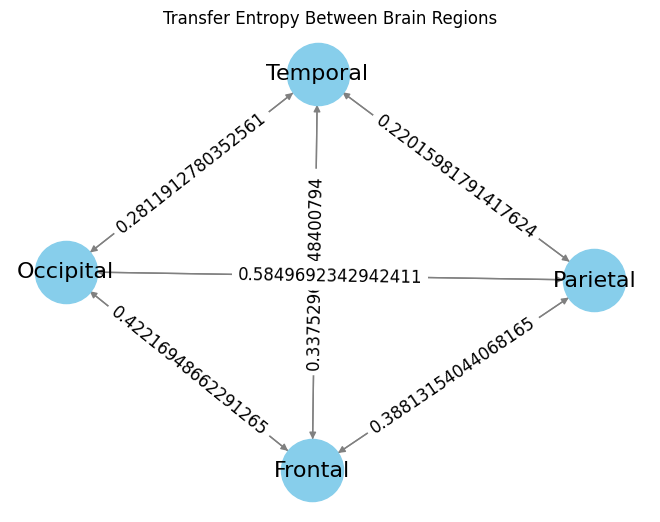

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Load Transfer Entropy results from the saved .npy file
results_file_path = '/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Transfer Entropy/regional_transfer_entropy_results.npy'
TE_results = np.load(results_file_path, allow_pickle=True).item()

G = nx.DiGraph()  # Create a directed graph

# Add edges to the graph
for key, value in TE_results.items():
    source, target = key.split("_to_")
    G.add_edge(source, target, weight=value)

# Draw the graph
pos = nx.spring_layout(G)  # Positioning of nodes
labels = nx.get_edge_attributes(G, 'weight')

nx.draw(G, pos, with_labels=True, node_color='skyblue', font_size=16, font_color='black', node_size=2000, edge_color='grey')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=12)
plt.title('Transfer Entropy Between Brain Regions')
plt.show()